<h1 style="text-align:center; color:green; font-size:48px;">
Step 1: Base Heating Network
</h1>

#### Install libraries (if you did not do it before on the terminal)

In [9]:
# !pip install numpy==2.0.2 pandas==2.3.1
# !pip install matplotlib
# !pip install git+https://github.com/oemof/dhnx.git@dev
# !pip install osmnx==1.9.4 oemof.solph==0.5.6

# Import libraries

In [10]:
import matplotlib.pyplot as plt
import dhnx
import pandas as pd
import oemof.solph
from pyomo.environ import SolverFactory


## 1.1 Create network and plot

In [11]:
# Initialize thermal network
network = dhnx.network.ThermalNetwork()

# Load town parameter
network = network.from_csv_folder(r"STEP_1/twn_data")
    
# Load investment parameter
invest_opt = dhnx.input_output.load_invest_options(r"STEP_1/invest_data")

No sequences found to create timeindex from


In [12]:
print(network)

dhnx.network.ThermalNetwork object with these components
 * 2 producers
 * 5 consumers
 * 5 forks
 * 14 pipes



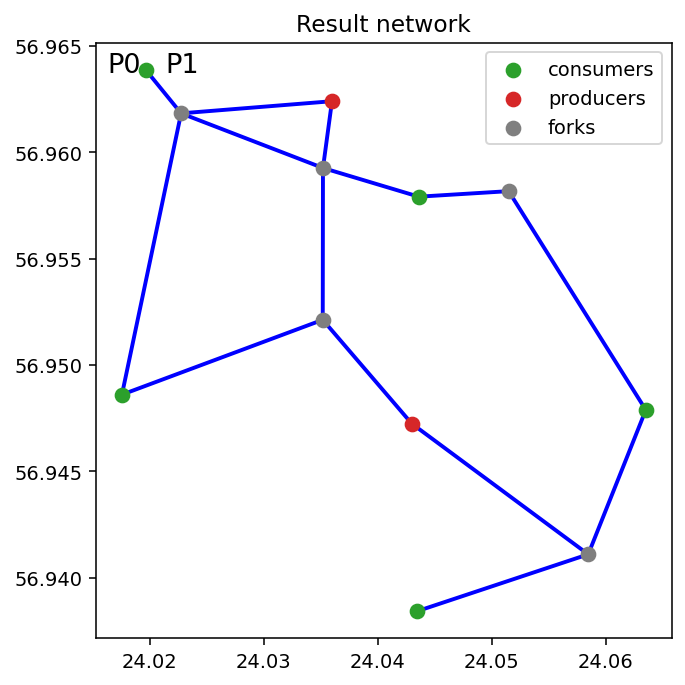

In [13]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_1 = dhnx.plotting.StaticMap(network)
static_map_1.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

## 1.2 Investment optimization of the network

In [14]:
# Optimize the investment data
# Check available solvers and use an appropriate one
available_solvers = ['gurobi', 'cbc', 'glpk']
solver_to_use = None

for solver in available_solvers:
	if SolverFactory(solver).available():
		solver_to_use = solver
		print(f"Using solver: {solver}")
		break

network.optimize_investment(invest_options=invest_opt,  solver=solver_to_use)

INFO:dhnx.optimization.optimization_models:Initialize the energy system


INFO:dhnx.optimization.optimization_models:Create oemof objects
INFO:dhnx.optimization.optimization_models:Producers, Consumers Nodes appended.
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\solph\flows\_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\network\network\nodes.py:250: FutureWarning: Usage of oemof.network.Component is deprecated. Use oemof.network.Node instead.
  warnings.warn(
INFO:dhnx.optimization.optimization_models:DHS Nodes appended.
INFO:dhnx.optimization.optimization_models:Energysystem has been created
INFO:dhnx.optimization.optimization_models:Build the operational model


Using solver: gurobi


INFO:dhnx.optimization.optimization_models:Solve the optimization problem
INFO:gurobipy:Read LP format model from file C:\Users\irfan\AppData\Local\Temp\tmp6finfakl.pyomo.lp
INFO:gurobipy:Reading time = 0.07 seconds
INFO:gurobipy:x1: 300 rows, 258 columns, 674 nonzeros


Read LP format model from file C:\Users\irfan\AppData\Local\Temp\tmp6finfakl.pyomo.lp
Reading time = 0.07 seconds
x1: 300 rows, 258 columns, 674 nonzeros


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))


INFO:gurobipy:


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


INFO:gurobipy:Optimize a model with 300 rows, 258 columns and 674 nonzeros
INFO:gurobipy:Model fingerprint: 0x3836d3c1


Optimize a model with 300 rows, 258 columns and 674 nonzeros


INFO:gurobipy:Variable types: 226 continuous, 32 integer (32 binary)


Model fingerprint: 0x3836d3c1
Variable types: 226 continuous, 32 integer (32 binary)


INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [4e-04, 7e+03]
INFO:gurobipy:  Objective range  [8e+01, 2e+07]


Coefficient statistics:
  Matrix range     [4e-04, 7e+03]
  Objective range  [8e+01, 2e+07]


INFO:gurobipy:  Bounds range     [1e+00, 7e+03]
INFO:gurobipy:  RHS range        [1e+02, 3e+03]


  Bounds range     [1e+00, 7e+03]
  RHS range        [1e+02, 3e+03]


INFO:gurobipy:Presolve removed 258 rows and 200 columns


Presolve removed 258 rows and 200 columns


INFO:gurobipy:Presolve time: 0.01s
INFO:gurobipy:Presolved: 42 rows, 58 columns, 154 nonzeros
INFO:gurobipy:Variable types: 36 continuous, 22 integer (22 binary)


Presolve time: 0.01s
Presolved: 42 rows, 58 columns, 154 nonzeros
Variable types: 36 continuous, 22 integer (22 binary)


INFO:gurobipy:Found heuristic solution: objective 6.723122e+07


Found heuristic solution: objective 6.723122e+07


INFO:gurobipy:Found heuristic solution: objective 6.411654e+07


Found heuristic solution: objective 6.411654e+07


INFO:gurobipy:Found heuristic solution: objective 6.121540e+07
INFO:gurobipy:
INFO:gurobipy:Root relaxation: objective 3.000746e+07, 40 iterations, 0.00 seconds (0.00 work units)


Found heuristic solution: objective 6.121540e+07

Root relaxation: objective 3.000746e+07, 40 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy:


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time
INFO:gurobipy:
INFO:gurobipy:     0     0 3.0007e+07    0    6 6.1215e+07 3.0007e+07  51.0%     -    0s


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.0007e+07    0    6 6.1215e+07 3.0007e+07  51.0%     -    0s


INFO:gurobipy:H    0     0                    5.418263e+07 3.0007e+07  44.6%     -    0s


H    0     0                    5.418263e+07 3.0007e+07  44.6%     -    0s


INFO:gurobipy:H    0     0                    4.952168e+07 3.0007e+07  39.4%     -    0s


H    0     0                    4.952168e+07 3.0007e+07  39.4%     -    0s


INFO:gurobipy:     0     0 3.8645e+07    0    7 4.9522e+07 3.8645e+07  22.0%     -    0s


     0     0 3.8645e+07    0    7 4.9522e+07 3.8645e+07  22.0%     -    0s


INFO:gurobipy:H    0     0                    4.710418e+07 3.9155e+07  16.9%     -    0s


H    0     0                    4.710418e+07 3.9155e+07  16.9%     -    0s


INFO:gurobipy:     0     0 4.0616e+07    0    6 4.7104e+07 4.0616e+07  13.8%     -    0s
INFO:gurobipy:     0     0 4.0947e+07    0    5 4.7104e+07 4.0947e+07  13.1%     -    0s


     0     0 4.0616e+07    0    6 4.7104e+07 4.0616e+07  13.8%     -    0s
     0     0 4.0947e+07    0    5 4.7104e+07 4.0947e+07  13.1%     -    0s


INFO:gurobipy:     0     0 4.2511e+07    0    7 4.7104e+07 4.2511e+07  9.75%     -    0s


     0     0 4.2511e+07    0    7 4.7104e+07 4.2511e+07  9.75%     -    0s


INFO:gurobipy:     0     0 4.4029e+07    0    4 4.7104e+07 4.4029e+07  6.53%     -    0s


     0     0 4.4029e+07    0    4 4.7104e+07 4.4029e+07  6.53%     -    0s


INFO:gurobipy:     0     0 4.6025e+07    0    5 4.7104e+07 4.6025e+07  2.29%     -    0s


     0     0 4.6025e+07    0    5 4.7104e+07 4.6025e+07  2.29%     -    0s


INFO:gurobipy:     0     0 4.6314e+07    0    7 4.7104e+07 4.6314e+07  1.68%     -    0s
INFO:gurobipy:     0     0 4.6537e+07    0    4 4.7104e+07 4.6537e+07  1.20%     -    0s


     0     0 4.6314e+07    0    7 4.7104e+07 4.6314e+07  1.68%     -    0s
     0     0 4.6537e+07    0    4 4.7104e+07 4.6537e+07  1.20%     -    0s


INFO:gurobipy:     0     0          -    0      4.7104e+07 4.7102e+07  0.00%     -    0s


     0     0          -    0      4.7104e+07 4.7102e+07  0.00%     -    0s


INFO:gurobipy:
INFO:gurobipy:Cutting planes:


INFO:gurobipy:  Learned: 5


Cutting planes:
  Learned: 5


INFO:gurobipy:  Gomory: 2


  Gomory: 2


INFO:gurobipy:  Cover: 1


  Cover: 1


INFO:gurobipy:  Implied bound: 5


  Implied bound: 5


INFO:gurobipy:  Clique: 2


  Clique: 2


INFO:gurobipy:  MIR: 3
INFO:gurobipy:  Flow cover: 3
INFO:gurobipy:


  MIR: 3
  Flow cover: 3



INFO:gurobipy:Explored 1 nodes (111 simplex iterations) in 0.69 seconds (0.00 work units)


Explored 1 nodes (111 simplex iterations) in 0.69 seconds (0.00 work units)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


Thread count was 8 (of 8 available processors)



INFO:gurobipy:
INFO:gurobipy:Solution count 6: 4.71042e+07 4.95217e+07 5.41826e+07 ... 6.72312e+07


Solution count 6: 4.71042e+07 4.95217e+07 5.41826e+07 ... 6.72312e+07


INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)
INFO:gurobipy:Best objective 4.710418213993e+07, best bound 4.710249495383e+07, gap 0.0036%



Optimal solution found (tolerance 1.00e-04)
Best objective 4.710418213993e+07, best bound 4.710249495383e+07, gap 0.0036%


INFO:root:Optimization successful...


## 1.3 Results postprocessing and Plotting 


In [15]:
# ####### Postprocessing and Plotting ###########
results_edges = network.results.optimization['components']['pipes']
print(results_edges[['from_node', 'to_node', 'hp_type', 'capacity',
                     'direction', 'costs', 'losses']])

results_edges.to_csv("STEP_1/Outputs/Optimum_network_base.csv", index=True)

print('Objective value: ', network.results.optimization['oemof_meta']['objective'])

# assign new ThermalNetwork with invested pipes
twn_results = network
twn_results.components['pipes'] = results_edges[results_edges['capacity'] > 0.001]



      from_node      to_node hp_type     capacity  direction         costs  \
id                                                                           
0       forks-1  consumers-0    DN80   908.669134          1  1.966992e+06   
1   producers-1      forks-1    None     0.000000          0  0.000000e+00   
2   producers-1      forks-0    DN80  1231.864799          1  2.521603e+06   
3       forks-1      forks-0    DN80   914.344349         -1  3.506887e+06   
4       forks-1  consumers-1    None     0.000000          0  0.000000e+00   
5       forks-0      forks-3    None     0.000000          0  0.000000e+00   
6       forks-0  consumers-2    DN80   313.158375          1  3.724926e+06   
7       forks-4  consumers-2    None     0.000000          0  0.000000e+00   
8       forks-4  consumers-3    None     0.000000          0  0.000000e+00   
9       forks-3  producers-0    DN80  1446.118308         -1  4.087648e+06   
10  producers-0      forks-2   DN125  2818.376746          1  8.

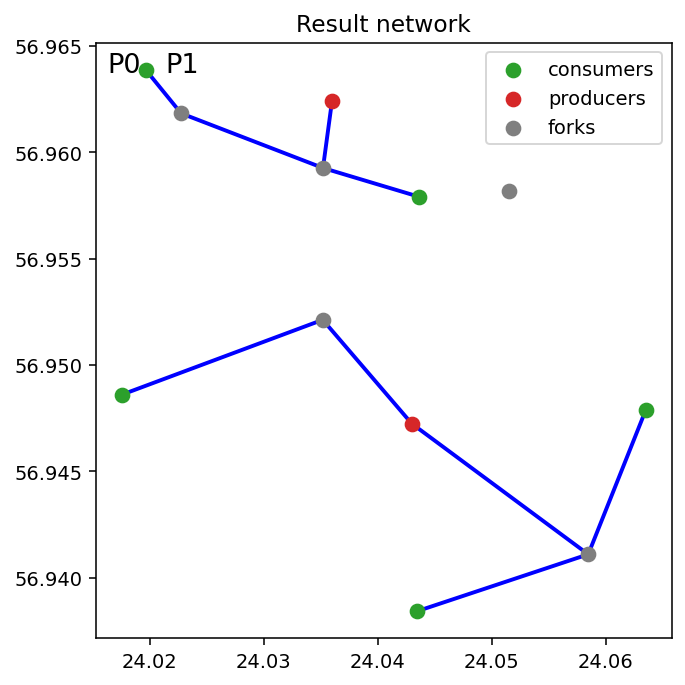

In [16]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_2 = dhnx.plotting.StaticMap(twn_results)
static_map_2.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()